In [1]:
from fipy import Grid3D, Grid2D, CellVariable, Viewer, numerix
from fipy import DiffusionTerm, ExplicitDiffusionTerm, TransientTerm, ImplicitDiffusionTerm
from IPython.display import clear_output

import numpy as np
import plotting_utils
import parameterfunctions as fct

from parameters import *

In [2]:
mesh = Grid3D(nx = N_x, ny = N_y, nz = N_z, dx = dx, dy = dy, dz = dz)

x = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[0])
y = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[1])
z = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[2])

temperature = CellVariable(mesh = mesh, name = 'temperature', value=300.0)
pressure = CellVariable(mesh = mesh, name = 'pressure')
v_x = CellVariable(mesh = mesh, name = 'x-velocity', value=10.0)
v_y = CellVariable(mesh = mesh, name = 'y-velocity', value=0.0)
v_z = CellVariable(mesh = mesh, name = 'z-velocity', value=0.0)
sensible_heat = CellVariable(mesh = mesh, name = 'sensible heat', value=0.0)
latent_heat = CellVariable(mesh = mesh, name = 'latent heat', value=0.0)

velocity = CellVariable(mesh = mesh, name = 'velocity', rank = 1, value = numerix.array([numerix.array(v_x), numerix.array(v_y), numerix.array(v_z)]))

In [30]:
#starting values:
x_pos = 0.0001
layer = 1
hatch = 2.5
time = 0.0

#layer of laser impact:
N = round(mesh.nz / layers) * layer - 1

#initializing the material parameters
liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
laser_factor = CellVariable(mesh = mesh, value = ((1-liquid)*steel_powder_absoprtion+liquid*steel_liquid_absoprtion)*distribution_factor*laser_power/(numerix.pi*beam_radius**2*layer_thickness))
c = (1-liquid)*fct.get_effective_specific_heat(argon_density, steel_density, packing_efficiency, argon_density, temperature, mesh) + liquid*steel_fluid_c
k = (1-liquid)*fct.get_effective_cond(mesh, temperature, packing_efficiency)+liquid*fct.get_steel_thermal_conductivity(mesh, temperature)
rho = fct.get_effective_density(argon_density, steel_density, packing_efficiency)*(1-liquid) + liquid*steel_density_liquid
alpha = k/(rho*c)

#initializing the source term 
source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)*dt
source = numerix.where(numerix.absolute(z-layer*layer_thickness) < layer_thickness, source_value, 0.0)
source_term = CellVariable(mesh = mesh, name = 'source', value=source)

konv_diff_eq = TransientTerm(var = sensible_heat) == DiffusionTerm(var = sensible_heat, coeff=alpha) + source_term - liquid*steel_latent_heat*dt
sensible_heat.faceGrad.constrain(-c.faceValue[mesh.facesTop]*sigma+steel_emissivity*(temperature.faceValue[mesh.facesTop]**4-300**4)/k.faceValue[mesh.facesTop], mesh.facesTop[2])

for i in range(time_steps):
    
    print(i)
    print(time)
    
    #setting new source term:
    source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)*dt
    source = numerix.where(numerix.absolute(z-layer*layer_thickness) < layer_thickness, source_value, 0.0)
    source_term.setValue(source)

    #update material paramters:
    c = (1-liquid)*fct.get_effective_specific_heat(argon_density, steel_density, packing_efficiency, argon_density, temperature, mesh) + liquid*steel_fluid_c
    k = fct.get_effective_cond(mesh, temperature, packing_efficiency)
    liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
    
    #saving old heat for temperature change:
    heat_old = numerix.array(sensible_heat) 
    
    #finite-volume solving:
    res = konv_diff_eq.sweep(dt = dt)

    #calculate temperature change and add:
    temperature.setValue(numerix.array(temperature) + 1/c*(sensible_heat-heat_old)) 
    
    #updating laser position
    x_pos +=dt*scanning_speed
    time += dt
    clear_output()
    
    if x_pos >= L_x:
        
        hatch += 1
        x_pos = 0.0
        
        if hatch == hatches:
            
            layer += 1
            hatch = 0
            
            if layer == layers:
                
                break
                
plotting_utils.plot_2d_xy(temperature, N)

0
0.0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 55000 but corresponding boolean dimension is 172100

In [6]:
data = np.array(temperature)
np.save('temperature', data)

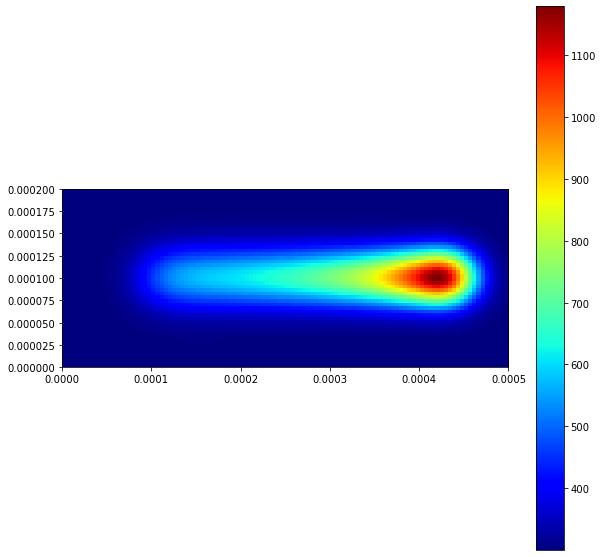

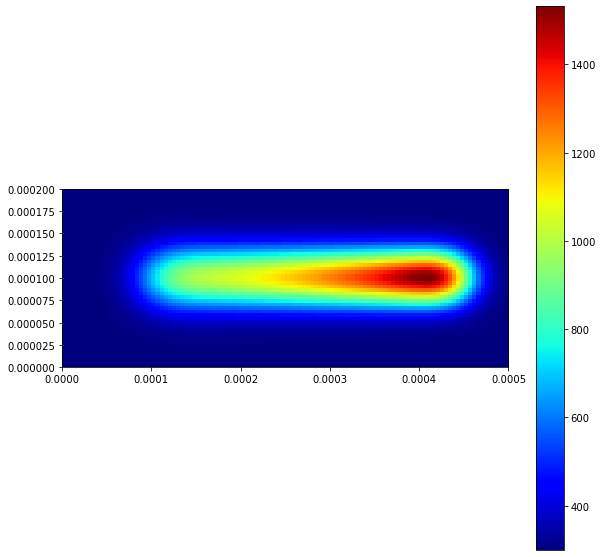

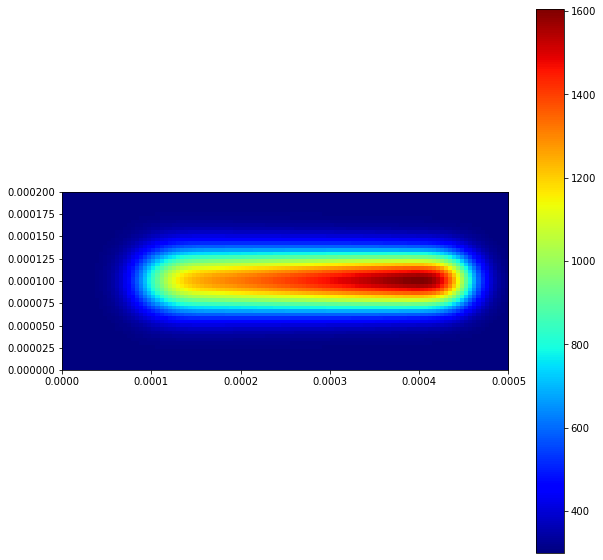

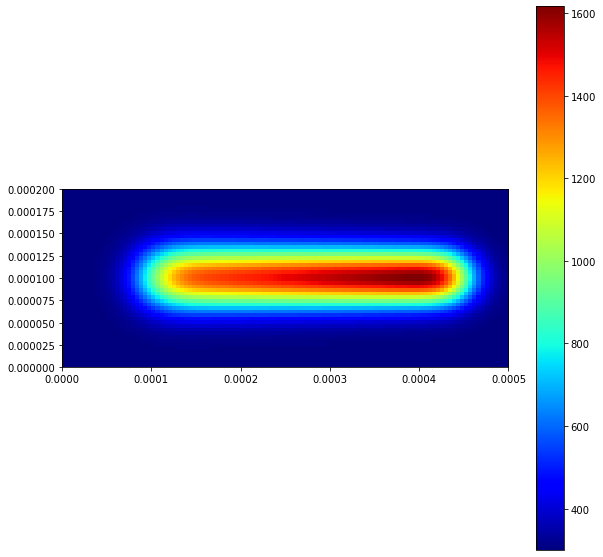

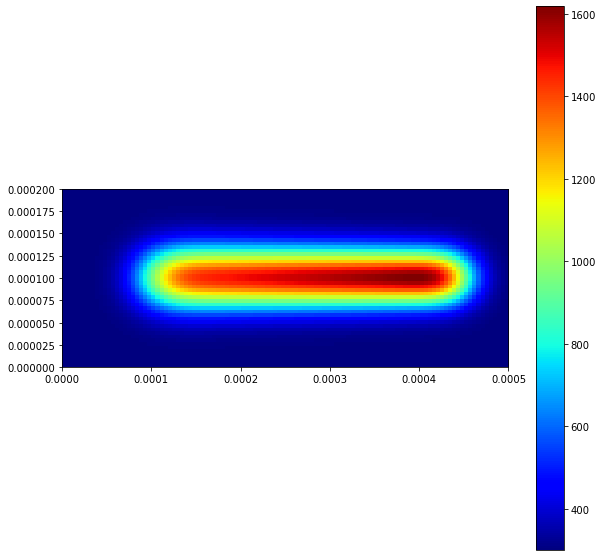

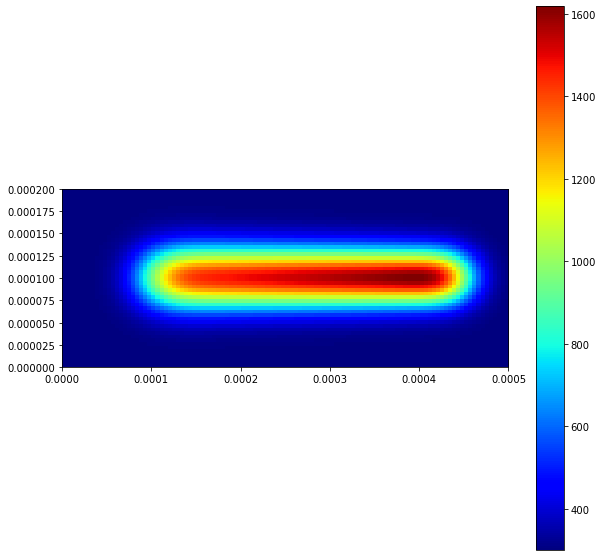

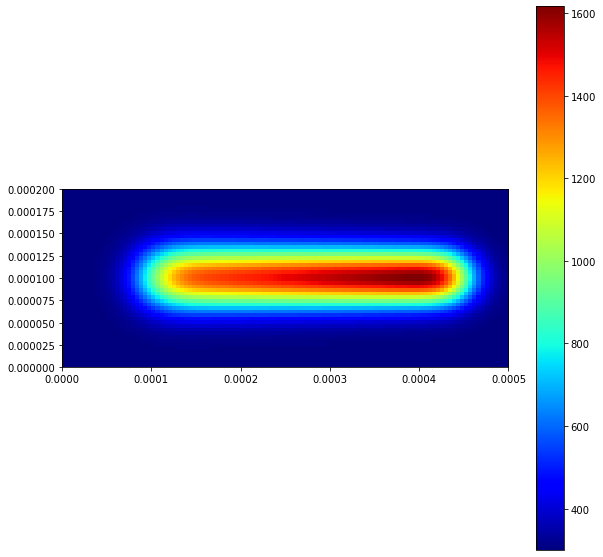

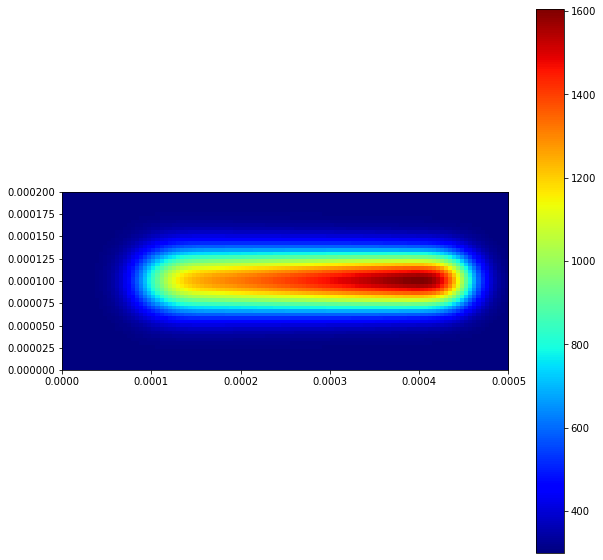

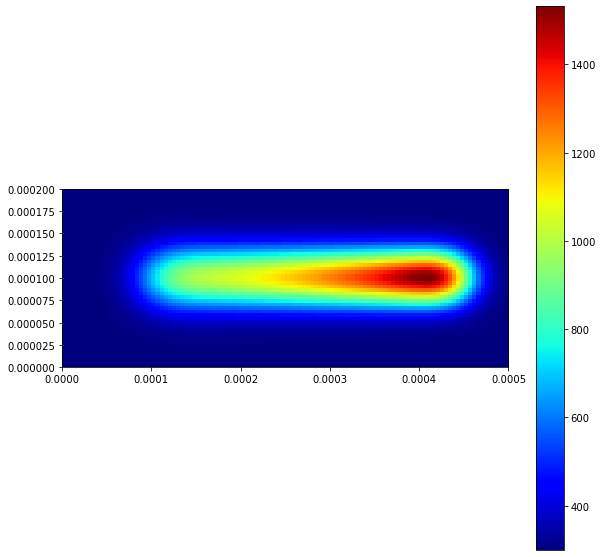

In [7]:
data = np.load('temperature.npy')
temperature.setValue(data)

for i in range(mesh.nz-1):

    plotting_utils.plot_2d_xy(temperature, i)

In [8]:
liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
plotting_utils.plot_2d_xy(liquid, N)

Value of N too high


In [10]:
viewer = Viewer(vars=(temperature))

In [9]:
np.array(c).shape

(55000,)

In [14]:
sensible_heat.faceGrad.constrain(1, mesh.facesTop)

In [24]:
np.array(k.faceGrad[:,mesh.facesTop][2]).shape

(1100,)

In [27]:
np.array(k.faceValue[mesh.facesTop]).shape

(1100,)